# Notebook I - Climate Regime
<hr>
This module performs climate data analysis and compiling general agro-climatic indicators. These general agro-climatic indicators summarize climatic profiles in the study area for each grid. The key input data for this module is the climatic data, and the geographical and terrain data.

Prepared by Geoinformatics Center, AIT
<hr>


### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal
# # !pip install pyaez==2.0.0


# K:\projects\unfao\pyaez_gaez\repos\PyAEZ_kerrie\PyAEZ\pyaez_v2.1_2023JUL10\NB1_ClimateRegime_v2_1_China.ipynb

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
# import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys

from time import time as timer

import xarray as xr
import rioxarray as rio

import dask.array as da
import dask

Setting the working directory -- where our PyAEZ project is located.

In [2]:
# branch version tag
revname='v21pv'

# # HPC Orion
# # Replace with path to your PyAEZ folder under your username
# work_dir = '/work/hpc/users/kerrie/UN_FAO/repos/PyAEZ/pyaez2.1_vectorize/'
# # Replace with whatever location you want to output data under your username
# out_path = '/work/hpc/users/kerrie/UN_FAO/pyaez_results/china_8110/'+revname+'/' 
# # these are the same for everyone on HPC Orion
# data_dir = '/work/hpc/datasets/un_fao/pyaez/china_8110/daily/npy/'
# maskfile = '/work/hpc/datasets/un_fao/pyaez/china_static/netcdf/mask.nc'
# elevfile = '/work/hpc/datasets/un_fao/pyaez/china_static/tif/elev.tif'


# # Kerrie desktop
# work_dir = 'K:/projects/unfao/pyaez_gaez/repos/PyAEZ_kerrie/PyAEZ/pyaez2.1_vectorize/' # path to your PyAEZ repo
# out_path = work_dir+'NB1outputs/' # path for saving output data
# data_dir = 'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/npy/' # path to your data
# maskfile = 'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/mask.tif'# subset for no antarctica, 1800 lats
# elevfile = 'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/elev.tif'

# Kerrie laptop china
work_dir = 'C://Users/kerrie/Documents/01_LocalCode/repos/PyAEZ/pyaez2.1_parvec/' # path to your PyAEZ repo
out_path = work_dir+'NB1outputs/' # path for saving output data
# data_dir = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/npy/' # path to your data
# maskfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/mask.tif'# subset for no antarctica, 1800 lats
# elevfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/elev.tif'
data_dir = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/7GB/' # path to your data
maskfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/7GB/mask.tif'# subset for no antarctica, 1800 lats
elevfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/7GB/elev.tif'

# Kerrie laptop global
# work_dir = 'C://Users/kerrie/Documents/01_LocalCode/repos/PyAEZ/pyaez2.1_parvec/' # path to your PyAEZ repo
# out_path = work_dir+'NB1outputs/' # path for saving output data
# data_dir = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/npy/' # path to your data
# maskfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/tif/mask_2268708_5m.tif'# subset for no antarctica, 1800 lats
# elevfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/tif/Elevation_2268708_5m.tif'

# Check whether the specified path exists or not
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")

<hr>

## MODULE 1: CLIMATE REGIME
Now, we will start executing the routines in Module 1


First, we initiate Module 1 Class instance by invoking the following commands:

In [3]:
# %load_ext autoreload
# %autoreload 2
# Import Module 1 and initate Class intance
# from pyaez import ClimateRegime
# clim_reg = ClimateRegime.ClimateRegime()

# # Importing UtilitiesCalc
# from pyaez import UtilitiesCalc
# obj_util = UtilitiesCalc.UtilitiesCalc()

import ClimateRegime_v21pv as ClimateRegime
clim_reg = ClimateRegime.ClimateRegime()

import UtilitiesCalc_v21pv as UtilitiesCalc
obj_utilities=UtilitiesCalc.UtilitiesCalc()


### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m^2
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
- Soil/terrain/special land cover classes
  

**All the datasets must have the same shape.**

In [4]:
# expect 2 seconds run time for china
# expect s run time for global

start=timer()

# '''reading climate data'''

# Importing the climate data
# this data is for 1980 without the leap day, so 365 total days

# HPC Orion
# same file structure for Kerrie's SSC desktop
max_temp = np.load(data_dir+'Tmax-2m365/0.npy').astype('float32')  # maximum temperature
min_temp = np.load(data_dir+'Tmin-2m365/0.npy').astype('float32')  # minimum temperature
precipitation = np.load(data_dir+'Precip365/0.npy').astype('float32')  # precipitation
rel_humidity = np.load(data_dir+'Rhum365/0.npy').astype('float32')  # relative humidity
wind_speed = np.load(data_dir+'Wind-2m365/0.npy').astype('float32') # wind speed measured at two meters
short_rad = np.load(data_dir+'Srad365/0.npy').astype('float32')  # shortwave radiation
mask=gdal.Open(maskfile).ReadAsArray()
elevation=gdal.Open(elevfile).ReadAsArray()
# soil_terrain_lulc = gdal.Open(r'./data_input/LAO_soil_terrain_lulc.tif').ReadAsArray()
# I don't know how to create the soil_terrain_lulc.tif for global

# chunks=(-1,94,-1)
# max_temp = da.from_npy_stack(data_dir+'Tmax-2m365/').astype('float32').rechunk(chunks=chunks)  # maximum temperature
# min_temp = da.from_npy_stack(data_dir+'Tmin-2m365/').astype('float32').rechunk(chunks=chunks)  # minimum temperature
# precipitation = da.from_npy_stack(data_dir+'Precip365/').astype('float32').rechunk(chunks=chunks)  # precipitation
# rel_humidity = da.from_npy_stack(data_dir+'Rhum365/').astype('float32').rechunk(chunks=chunks)  # relative humidity
# wind_speed = da.from_npy_stack(data_dir+'Wind-2m365/').astype('float32').rechunk(chunks=chunks) # wind speed measured at two meters
# short_rad = da.from_npy_stack(data_dir+'Srad365/').astype('float32').rechunk(chunks=chunks)  # shortwave radiation

# # Load the geographical data/rasters
# mask=da.from_array(gdal.Open(maskfile).ReadAsArray()).rechunk(chunks=(-1,94))
# elevation=da.from_array(gdal.Open(elevfile).ReadAsArray()).rechunk(chunks=(-1,94))



print(min_temp.shape,mask.shape)

task_time=timer()-start
task_time

(1800, 444, 365) (1800, 444)


c:\Users\kerrie\.conda\envs\pyaez_dask\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


4.202293395996094

In [5]:
(max_temp.nbytes+min_temp.nbytes+precipitation.nbytes+rel_humidity.nbytes+wind_speed.nbytes+short_rad.nbytes+mask.nbytes+elevation.nbytes)/1E9

7.0073856

This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)

In [6]:
# Define the Area-Of-Interest's geographical extents

# if lat_min/lat_max values defined below are located at pixel center --> set lat_centers to True 
# if they are located at the exterior pixel edge --> set lat_centers to False
lat_centers=True 

# provide min and max latitudes (either set manually or read from a data file)
# lat_min = 18.04167
# lat_max = 53.625
lats=rio.open_rasterio(maskfile)['y'].data   # get array of latitudes from maskfile
lat_min = np.trunc(lats.min()*100000)/100000 # min lat value at pixel center, limit precision to 5 decimal places
lat_max = np.trunc(lats.max()*100000)/100000 # max lat value at pixel center, limit precision 5 decimal places

# mask information
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
mask_path=maskfile

# time resolution information
daily = True #Type of climate data = True: daily, False: monthly

### Loading the imported data into the Object Class ('*clim_reg*' Class)

In [7]:
# expect >1s run time for china
start=timer()

clim_reg.setStudyAreaMask(mask, mask_value)

task_time=timer()-start
task_time

0.0

In [8]:
clim_reg.__dict__.keys()

dict_keys(['im_mask', 'nodata_val', 'set_mask'])

In [9]:
# expect >1s run time for china
start=timer()

clim_reg.setLocationTerrainData(lat_min, lat_max, lat_centers, elevation) #KLG

task_time=timer()-start
task_time

0.002000570297241211

In [10]:
# expect ~30 seconds run time for china

start=timer()

if daily:
    clim_reg.setDailyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
else:
    clim_reg.setMonthlyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
    
task_time=timer()-start
task_time    

103.19760942459106

In [11]:
'Releasing the memory of input climate data -- free up some RAM space'
del(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [12]:
# get a list of all the data in the class instance clim_reg

data_labels=clim_reg.__dict__.keys()
data_labels

dict_keys(['im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude', 'doy_start', 'doy_end', 'maxT_daily', 'minT_daily', 'totalPrec_daily', 'meanT_daily', 'pet_daily', 'meanT_daily_sealevel', 'P_by_PET_daily', 'set_monthly', 'interp_daily_temp', 'chunk3D', 'chunk2D'])

In [14]:
# # sanity check
# # plot 2D & 3D data, print value of scalars 

# for key in data_labels:
#     print(key)    
#     try:
#         ndims=len(clim_reg.__getattribute__(key).shape)
#         # dims=clim_reg.__getattribute__(key).shape
#     except:
#         ndims=1
#     if ndims==1:
#         print(key,'=',clim_reg.__getattribute__(key))
#     if ndims==2:
#         plt.imshow(clim_reg.__getattribute__(key),interpolation='none')
#         plt.colorbar(shrink=0.5)
#         plt.title(key)
#         plt.show()
#     if ndims==3:
#         plt.imshow(clim_reg.__getattribute__(key)[:,:,0],interpolation='none')
#         plt.colorbar(shrink=0.5)
#         plt.title(key)
#         plt.show()

In [15]:
# data_list=[]
# for key in data_labels:
#     data_list.append(clim_reg.__getattribute__(key))

# data_list

In [16]:
# fut_climreg=dask.persist(*data_list)

# fut_climreg.result()

In [17]:
# da_vars=clim_reg.meanT_daily
# da_vars.store(clim_reg.meanT_daily,return_stored=True)
# da_vars


In [18]:
# fut_climreg

NOTE: After loading the data into the *clim_reg* Class, all the parameters will be converted to DAILY DATA and calculated as other parameters. 
These new parameters are available and can be called into use as:
- *clim_reg.minT_daily* (minimum temperature)
- *clim_reg.maxT_daily* (maximum temperature)
- *clim_reg.meanT_daily* (mean temperature)
- *clim_reg.meanT_daily_sealevel* (mean temperature, corrected to sea-level)
- *clim_reg.totalPrec_daily* (total precipitation)
- *clim_reg.pet_daily* (reference evapotranspiration, ETo)
- *clim_reg.P_by_PET_daily* (ratio of precipitation over ETo)
  


#### Thermal Climate
The Thermal Climate function calculates and classifies latitudinal thermal climate, which will be used later in Module 2 for the assessment of potential crops and land utilization types (LUT) presence in each grid cell.

In [13]:
# expect >1s run time for china
# non-vectorized: expect ~50 seconds run time for china
start=timer()

tclimate = clim_reg.getThermalClimate()

task_time=timer()-start
task_time

c:\Users\kerrie\.conda\envs\pyaez_dask\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<__array_function__ internals>:200: RuntimeWarning: overflow encountered in cast


1.493157148361206

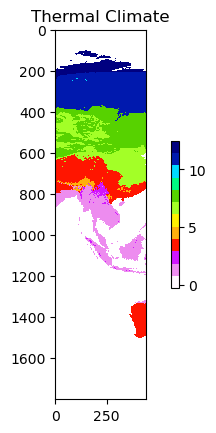

In [14]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(tclimate, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5,interpolation='none')
plt.title('Thermal Climate')
plt.colorbar(shrink=0.4)
plt.savefig(out_path+"ThermalClimate.png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

In [15]:
obj_utilities.saveRaster(mask_path, out_path+'ThermalClimate_'+revname+'.tif',tclimate) #Save as GeoTIFF raster

#### Thermal Zone
The thermal zone is classified based on actual temperature which reflects on the temperature regimes of major thermal climates

In [16]:
# expect >1s run time for china
# non-vectorized: expect ~35 seconds run time for china
start=timer()

tzone = clim_reg.getThermalZone()

task_time=timer()-start
task_time

0.4639928340911865

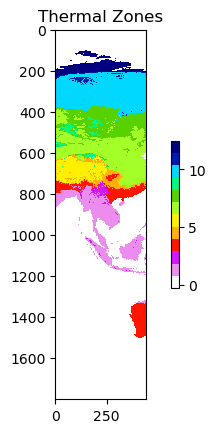

In [17]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(tzone, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5,interpolation='none')
plt.title('Thermal Zones')
plt.colorbar(shrink=0.4)
plt.savefig(out_path+"ThermalZone"+revname+".png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

obj_utilities.saveRaster(mask_path, out_path+'ThermalZone'+revname+'.tif',tzone) #Save as GeoTIFF raster

#### Thermal Length of Growing Period (LGP)
The thermal length of growing period (LGPt) is defined as the number of days in a year during which the daily mean temperature (Ta) is conductive to crop growth and development. PyAEZ utilizes the AEZ three standard temperature thresholds for LGPt:
- Periods with Ta>0°C (LGPt0)
- Periods with Ta>5°C (LGPt5) – the period conductive to plant growth and development
- Periods, and Ta>10°C (LGPt10) – a proxy for the period of low risks for late and early frost occurrences and termed ‘frost-free period’

In [18]:
# expect >1s run time for china
# non-vectorized: expect ~1 second run time for china
start=timer()

lgpt0 = clim_reg.getThermalLGP0()
lgpt5 = clim_reg.getThermalLGP5()
lgpt10 = clim_reg.getThermalLGP10()

task_time=timer()-start
task_time

0.6854181289672852

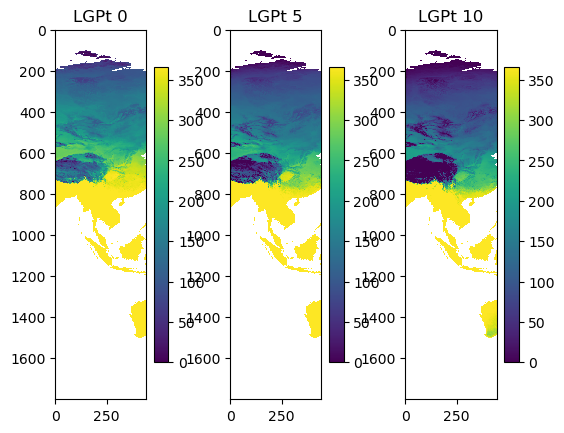

In [19]:
'''save and visualize result'''
#======================
# plt.figure(figsize=(20, 4),dpi=300)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(lgpt0,vmin=0,vmax=366,interpolation='none')
plt.title('LGPt 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(lgpt5, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(lgpt10, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig(out_path+"ThermalLGPs"+revname+".png",
            bbox_inches="tight", dpi=300)
plt.show()
#======================

obj_utilities.saveRaster(mask_path, out_path+'LGPt0_'+revname+'.tif', lgpt0)
obj_utilities.saveRaster(mask_path, out_path+'LGPt5_'+revname+'.tif', lgpt5)
obj_utilities.saveRaster(mask_path, out_path+'LGPt10_'+revname+'.tif', lgpt10)


#### Temperature Sum

In [20]:
# expect >1s run time for china
# non-vectorized: expect ~1 second run time for china
start=timer()

tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

task_time=timer()-start
task_time

1.3926105499267578

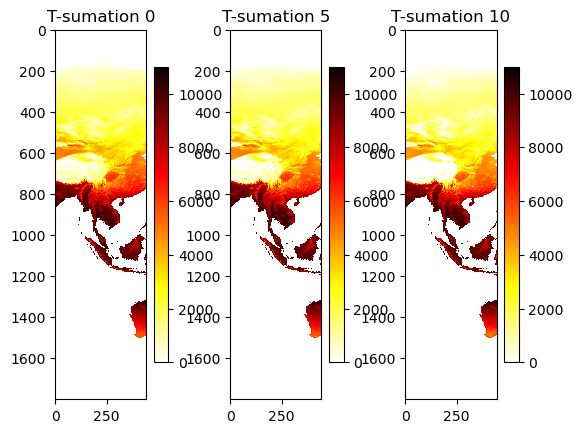

In [21]:
'''save and visualize result'''
#======================
# plt.figure(1, figsize=(20, 4),dpi=300)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(tsum0, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(tsum5, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(tsum10, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig(out_path+"Tsum_"+revname+".png",
            bbox_inches="tight", dpi=300)
plt.show()
#======================

In [22]:
obj_utilities.saveRaster(mask_path, out_path+'tsum0_'+revname+'.tif', tsum0)
obj_utilities.saveRaster(mask_path, out_path+'tsum5_'+revname+'.tif', tsum5)
obj_utilities.saveRaster(mask_path, out_path+'tsum10_'+revname+'.tif', tsum10)

#### Temperature Profile

In [23]:
# vectorized+parallel: expect ~1 second run time for china
# vectorized: expect ~6 seconds run time for china
# non-vectorized: expect ~50 seconds run time for china
start=timer()

tprofile = clim_reg.getTemperatureProfile()

task_time=timer()-start
task_time

4.230318069458008

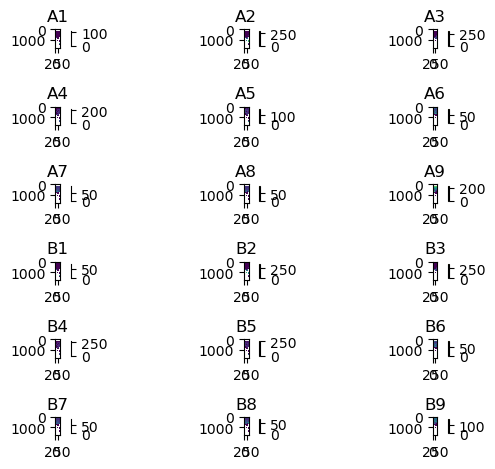

In [24]:
'''save and visualize result'''
tile_list = ['A1','A2','A3','A4','A5','A6','A7','A8','A9',
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

# fig = plt.figure(figsize=(12, 12))
fig = plt.figure()
for i1 in range(1, 19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1],interpolation='none')
    plt.title(tile_list[i1-1])
    plt.colorbar(shrink=0.8)
plt.tight_layout()

plt.savefig(out_path+"Tprofiles_"+revname+".png",bbox_inches="tight", dpi=300)
plt.show()


In [25]:
for i1 in range(18):
    obj_utilities.saveRaster(mask_path, out_path+'TProfile_' + tile_list[i1] +'_'+revname+'.tif', tprofile[i1])

#### Length of Growing Periods (LGPs)

In [44]:
@dask.delayed
def test_func1(x,y,z,X,Y,Z,mask):
    x=x*2
    y=y+3
    z=z**2
    X=np.where(mask,x,X)
    Y=np.where(mask,y,Y)
    Z=np.where(mask,z,Z)
    return X,Y,Z

def test_func2(out1,out2,out3):
    out1=out1+10
    out2=out2+20
    out3=out3+30
    return out1,out2,out3

@dask.delayed
def test_combine(x1,y1,z1,x2,y2,z2,mask1,mask2):
    x=np.empty(x1.shape)
    y=np.empty(x1.shape)
    z=np.empty(x1.shape)
    x=np.where(mask1,x1,x)
    x=np.where(mask2,x2,x)
    y=np.where(mask1,y1,y)
    y=np.where(mask2,y2,y)
    z=np.where(mask1,z1,z)
    z=np.where(mask2,z2,z)        
    return x,y,z




ndays=5
x_arr=np.ones((ndays,2,2),dtype='float32')
y_arr=np.zeros((ndays,2,2),dtype='float32')
z_arr=y_arr-1

X=np.empty(x_arr.shape)
Y=np.empty(y_arr.shape)
Z=np.empty(z_arr.shape)
X[:],Y[:],Z[:]=np.nan,np.nan,np.nan

# [[1,1],[1,1]]
mask1=np.array([[[1,0],[1,1]],[[1,0],[1,1]],[[1,0],[1,1]],[[1,0],[1,1]],[[1,0],[1,1]]])
mask2=np.array([[[0,1],[0,0]],[[0,1],[0,0]],[[0,1],[0,0]],[[0,1],[0,0]],[[0,1],[0,0]]])

mask1.shape

(5, 2, 2)

In [48]:
ncats=5
for i,cat in enumerate(np.arange(ncats)+1):
    print(i,cat)

0 1
1 2
2 3
3 4
4 5


In [45]:
task_list=[]
for doy in range(ndays):
    # task=test_func1(x_arr,y_arr,z_arr,X,Y,Z,mask1)
    # task_list.append(task)
    X,Y,Z=test_func1(x_arr,y_arr,z_arr,X,Y,Z,mask1)
    # task=test_func1(x_arr,y_arr,z_arr,X,Y,Z,mask2)
    # task_list.append(task)
    # task=test_combine()
    # print(task_list)
    # output=dask.compute(*task_list)


TypeError: Delayed objects of unspecified length are not iterable

In [42]:
len(output)
output[1]

(array([[[nan,  2.],
         [nan, nan]],
 
        [[nan,  2.],
         [nan, nan]],
 
        [[nan,  2.],
         [nan, nan]],
 
        [[nan,  2.],
         [nan, nan]],
 
        [[nan,  2.],
         [nan, nan]]]),
 array([[[nan,  3.],
         [nan, nan]],
 
        [[nan,  3.],
         [nan, nan]],
 
        [[nan,  3.],
         [nan, nan]],
 
        [[nan,  3.],
         [nan, nan]],
 
        [[nan,  3.],
         [nan, nan]]]),
 array([[[nan,  1.],
         [nan, nan]],
 
        [[nan,  1.],
         [nan, nan]],
 
        [[nan,  1.],
         [nan, nan]],
 
        [[nan,  1.],
         [nan, nan]],
 
        [[nan,  1.],
         [nan, nan]]]))

In [25]:
task_list=[]
for doy in range(ndays):
    # out1,out2,out3=test_func1(x_arr,y_arr,z_arr)
    task=test_func1(x_arr,y_arr,z_arr)
    # task=test_func2(out1,out2,out3)
    # task_list.append(task)
    output=task.compute()
    x_arr=output[0]
    y_arr=output[1]
    z_arr=output[2]
    

In [22]:
output=dask.compute(*task_list)

In [26]:
x_arr

array([[[1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.]],

       [[1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.]],

       [[1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
         1024.],
        [1024., 1

In [24]:
output[0][0]

array([[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],

       [[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],

       [[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],

       [[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2.,

In [26]:
# vectorized+parallel: expect ~66 seconds run time for china
# vectorized: expect ~1.5 minutes run time for china
# non-vectorized: expect ~6 minutes run time for china
start=timer()

lgp = clim_reg.getLGP(Sa=100., D=1.)
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

task_time=timer()-start
task_time

194.5458583831787

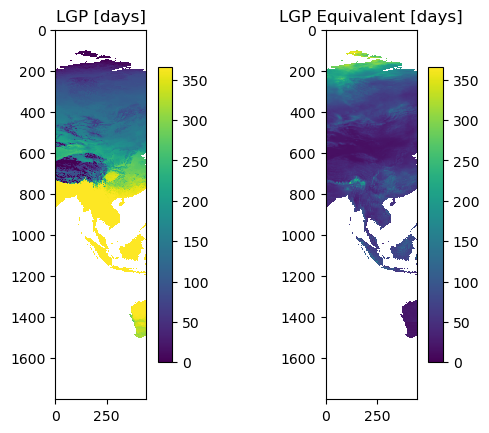

<Figure size 640x480 with 0 Axes>

In [27]:
'''save and visualize result'''
# fig = plt.figure(figsize=(20, 4))
fig = plt.figure()
# fig = plt.figure(figsize=(10, 8),dpi=600)
plt.subplot(121)
plt.imshow(lgp, cmap='viridis', vmin=0, vmax=366,interpolation='none')
plt.title('LGP [days]')
plt.colorbar(shrink=0.8)
# plt.savefig(out_path+"LGP_"+revname+".png", bbox_inches="tight", dpi=600)
# plt.show()

# fig = plt.figure(figsize=(20, 8),dpi=600)
plt.subplot(122)
plt.imshow(lgp_equv, cmap='viridis', vmin=0, vmax=366,interpolation='none')
plt.title('LGP Equivalent [days]')
plt.colorbar(shrink=0.8)
# plt.savefig(out_path+"LGP_Equv_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()

plt.savefig(out_path+"LGP_and_LGP_Equv_"+revname+".png",bbox_inches="tight", dpi=300)


obj_utilities.saveRaster(mask_path, out_path+'LGP_'+revname+'.tif', lgp)
obj_utilities.saveRaster(mask_path, out_path+'LGPEquivalent_'+revname+'.tif', lgp_equv)


#### Multi Cropping Zone
Multiple cropping zones classification is an additional agro-climatic indicator, which relates to the possibility of cultivating multiple sequential crops under rain-fed and irrigated conditions.

In [28]:
# expect >1s run time for china
# non-vectorized: expect ~1.5 minutes run time for china
start=timer()

multi_crop = clim_reg.getMultiCroppingZones(tclimate, lgp, lgpt5, lgpt10, tsum0, tsum10)
multi_crop_rainfed = multi_crop[0]  # for rainfed conditions
multi_crop_irr = multi_crop[1]  # for irrigated conditions

task_time=timer()-start
task_time

3.2278616428375244

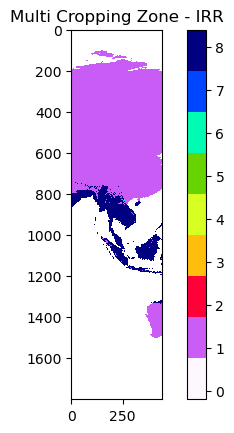

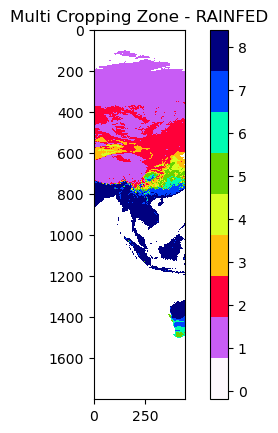

In [29]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(multi_crop_irr, cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4,interpolation='none')
plt.title('Multi Cropping Zone - IRR')
plt.colorbar()
plt.savefig(out_path+"multicrop_irr_"+revname+".png", bbox_inches="tight", dpi=300)
plt.show()

fig = plt.figure()
plt.imshow(multi_crop_rainfed,cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4,interpolation='none')
plt.title('Multi Cropping Zone - RAINFED')
plt.colorbar()
plt.savefig(out_path+"multicrop_rain_"+revname+".png",bbox_inches="tight", dpi=300)
plt.show()

obj_utilities.saveRaster(mask_path, out_path+'multicrop_irr_'+revname+'.tif', multi_crop_irr)
obj_utilities.saveRaster(mask_path, out_path+'multicrop_rain_'+revname+'.tif', multi_crop_rainfed)


### Air Frost Index and Permafrost Evaluation
Occurrence of continuous or discontinuous permafrost conditions are used in the suitability assessment. Permafrost areas are characterized by sub-soil at or below the freezing point for two or more years. In this section, PyAEZ utilizes the air frost index (FI) which is used to characterize climate-derived permafrost condition into 4 classes: 
1) Continuous permafrost
2) Discontinuous permafrost 
3) Sporadic permafrost
4) No permafrost

In [30]:
# expect >1s run time for china
# non-vectorized: expect ~2 seconds run time for china
start=timer()

permafrost_eval = clim_reg.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost = permafrost_eval[1]

task_time=timer()-start
task_time

1.8434460163116455

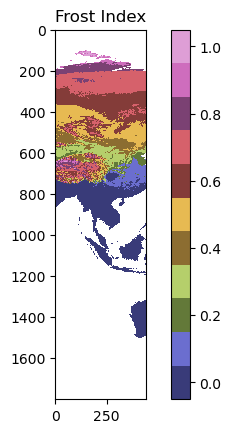

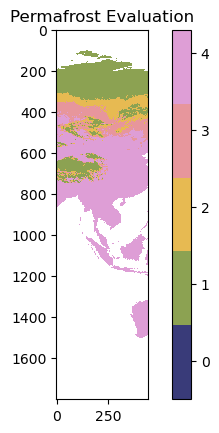

In [31]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(frost_index, cmap=plt.get_cmap('tab20b', 11), vmin=-0.05, vmax=1.05,interpolation='none')
plt.title('Frost Index')
plt.colorbar()
plt.savefig(out_path+"frost_index_"+revname+".png",bbox_inches="tight", dpi=300)
plt.show()

fig = plt.figure()
plt.imshow(permafrost, cmap=plt.get_cmap('tab20b', 5), vmin=-0.5, vmax=4.3,interpolation='none')
plt.title('Permafrost Evaluation')
plt.colorbar()
plt.savefig(out_path+"permafrost_"+revname+".png",bbox_inches="tight", dpi=300)
plt.show()


obj_utilities.saveRaster(mask_path, out_path+'frost_index_'+revname+'.tif', frost_index)
obj_utilities.saveRaster(mask_path, out_path+'permafrost_'+revname+'.tif', permafrost)


### Fallow period requirement
Fallow is an agricultural technique that consists of not sowing the arable land during one or more growing seasons. In AEZ framework, the fallow factors have been established by main crop groups and environmental conditions. The crop groups include cereals, legumes, roots and tubers, and a miscellaneous group consisting of long-term annuals/perennials. The fallow factors are expressed as percentage of time during the fallow-cropping cycle the land must be under fallow. PyAEZ determines the fallow requirements using Thermal Zones.

In [32]:
# expect >1s run time for china
# expect ~15 seconds run time for china
start=timer()

tzone_fallow = clim_reg.TZoneFallowRequirement(tzone)

task_time=timer()-start
task_time

0.2704472541809082

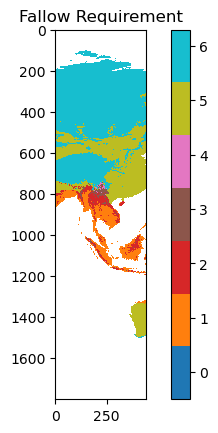

In [33]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(tzone_fallow, cmap=plt.get_cmap('tab10', 7), vmin=-0.5, vmax=6.3,interpolation='none')
plt.title('Fallow Requirement')
plt.colorbar()
plt.savefig(out_path+"fallow_"+revname+".png",bbox_inches="tight", dpi=300)
plt.show()

obj_utilities.saveRaster(mask_path, out_path+'fallow_'+revname+'.tif', tzone_fallow)


In [34]:
# check dtypes of all outputs
outputs=[tclimate,tzone,lgpt0,lgpt5,lgpt10,tsum0,tsum5,tsum10,tprofile,lgp,lgp_class,lgp_equv,multi_crop_rainfed,multi_crop_irr,frost_index,permafrost,tzone_fallow]
dtypes=[]
for var in outputs:
    # for arrays
    try:
        dt=var.dtype
        dtypes.append(dt)
    # for lists of arrays
    except:
        for v in var:
            dt=v.dtype
            dtypes.append(dt)

print(dtypes)

[dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32')]


### Agro-ecological zones classification
The agro-ecological zones (AEZ) methodology provides a framework for establishing a spatial inventory of land resources compiled from global/national environmental data sets and assembled to quantify multiple spatial characteristics required for the assessments of land productivity under location-specific agro-ecological conditions.

In [ ]:
# can't run until we have the global soil_terrain_lulc

# expect ~ minutes run time for global
start=timer()

aez = clim_reg.AEZClassification(
    tclimate, lgp, lgp_equv, lgpt5, soil_terrain_lulc, permafrost)

task_time=timer()-start
task_time

In [ ]:
# now visualizing result
fig = plt.figure(dpi=600)
plt.imshow(aez, cmap=plt.get_cmap('rainbow', 59), vmin=0, vmax=59,interpolation=None)
plt.title('Agro-ecological Zonation')
plt.colorbar()
plt.savefig(out_path+"aez_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()

obj_utilities.saveRaster(mask_path, out_path+'aez_'+revname+'.tif', aez)


<hr>

### END OF MODULE 1: CLIMATE REGIME

<hr>